# Eye For Blind

- Kanishk Mehta (kanishkmehta1995@gmail.com)

## Problem Statement

In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. 
- The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

The major steps that you have to perform can be briefly summarised in the following four steps:

- Data Understanding: Here, you need to load the data and understand the representation.
- Data Preprocessing: In this step, you will process both images and captions to the desired format.
- Train-Test Split: Combine both images and captions to create the train and test dataset.
- Model Building: This is the stage where you will create your image captioning model by building Encoder, Attention and Decoder model.
- Model Evaluation: Evaluate the models using greedy search and BLEU score.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
a=0

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if a==5:
            break
        a+=1

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flicker8k-data/captions.txt
/kaggle/input/flicker8k-data/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flicker8k-data/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flicker8k-data/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flicker8k-data/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flicker8k-data/Images/2190227737_6e0bde2623.jpg


In [2]:
# Importing the libraries

import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import shutil,sys
import pickle,json,glob
import tensorflow as tf
pd.set_option('display.max_colwidth',None)
# sns.set_style('whitegrid')

In [3]:
from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector
from tensorflow.keras.layers import Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
import keras
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.utils import shuffle

In [4]:
# Loading the images

path = '../input/flicker8k-data/Images'
images = os.listdir(path)
print("The total images present in the dataset: {}".format(len(images)))

# Creating the path to data set

img_path = []
for files in images:
    img_path.append(os.path.join(path,files))
print(img_path[0])

The total images present in the dataset: 8091
../input/flicker8k-data/Images/3226254560_2f8ac147ea.jpg


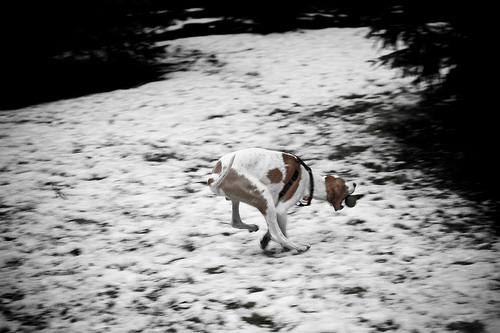

In [5]:
# Checking the image via path

Image.open(img_path[0])

In [6]:
# Reading the captions from the notepad file

def load_doc(filename):
    captions_file = open(filename,'r')
    captions = captions_file.readlines()
    captions_file.close()
    return captions
    
captions = '../input/flicker8k-data/captions.txt'
caps = load_doc(captions)
print("The total captions present in the text file: {}".format(len(caps[1:])))

The total captions present in the text file: 40455


In [7]:
# Creating the dataframe 

df = pd.DataFrame()
df[caps[0]] = caps[1:]
df['image_id'] = df['image,caption\n'].apply(lambda x : x.split(',')[0])
df['image_path'] = df['image,caption\n'].apply(lambda x : path+'/'+x.split(',')[0])

df['captions_orig'] = df['image,caption\n'].apply(lambda x : x.split(',')[-1])
df.drop(columns=['image,caption\n'],inplace=True)

df.head()

,image_id,image_path,captions_orig
0,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n
1,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n
2,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n
3,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n
4,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n


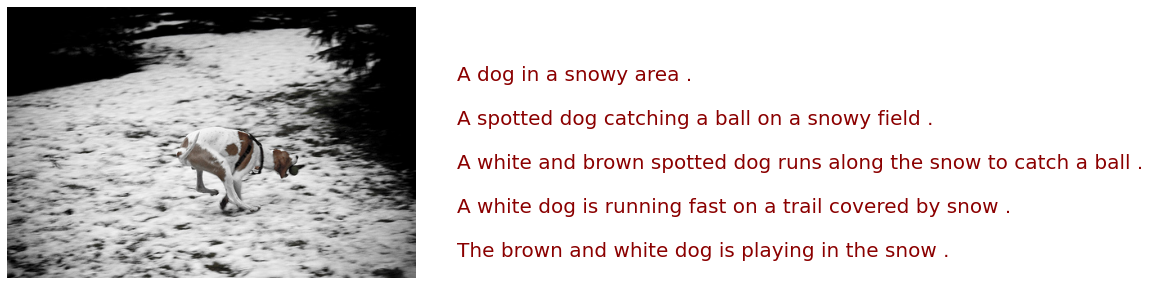

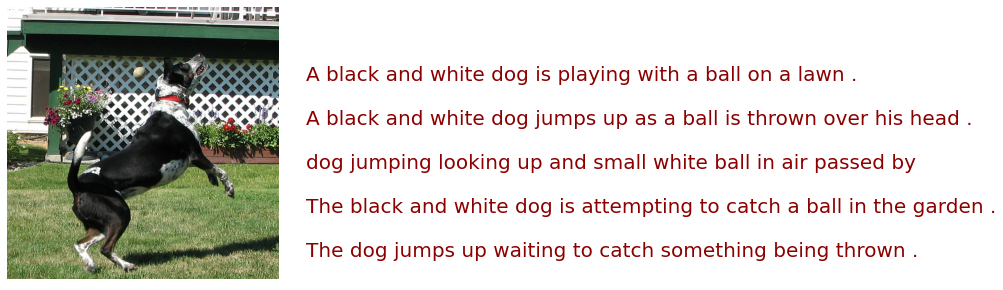

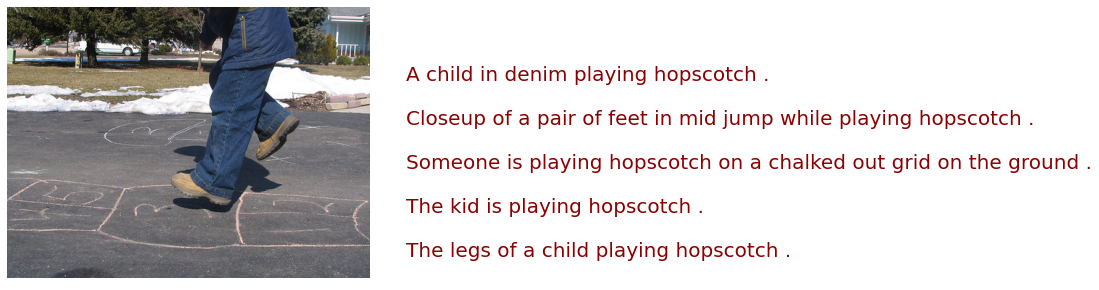

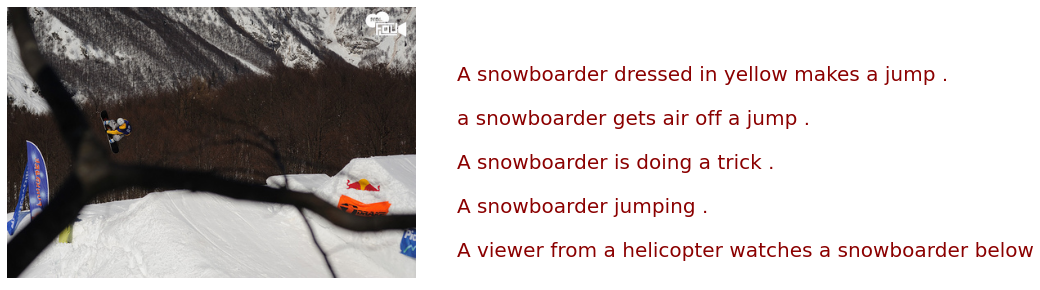

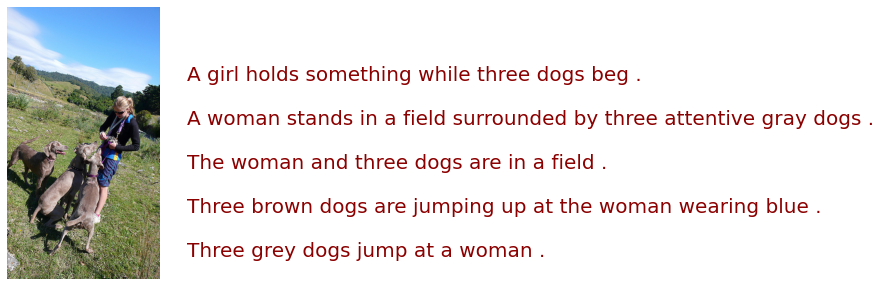

In [8]:
def check_data(data,img_id,ind):
    # Visualize the image and captions     
    fig, ax = plt.subplots(figsize=(10,5))
    img  =  plt.imread(img_path[ind])
    plt.imshow(img)
    h,w,ch = img.shape
    ax.text(x=w+50,y=h,s='\n'.join(df[df['image_id']==img_id]['captions_orig'].to_list()),color='darkred',fontsize=20)
    ax.set_axis_off()
    plt.show()

# Loop to show the images and captions
for i in range(0,5):
    check_data(data=df,img_id=images[i],ind=i)

In [9]:
from collections import Counter

def count_words(df,text):
    
    # Counter to get the number of words repeated
    counts = []
    for val in df[text]:
        counts+= val.split()
    counters = Counter(counts)
    keys = counters.keys()
    values = counters.values()
    word_counts =  pd.DataFrame()
    word_counts['Words'] = keys
    word_counts['Count'] = values
    words_sorted =  word_counts.sort_values(by='Count',ascending=False)
    return words_sorted

counts = count_words(df,'captions_orig')
counts.head(30)

,Words,Count
3,a,38810
15,.,34212
0,A,21480
2,in,18123
23,the,14882
38,on,10310
6,is,9086
29,and,8430
28,dog,7719
35,with,7396


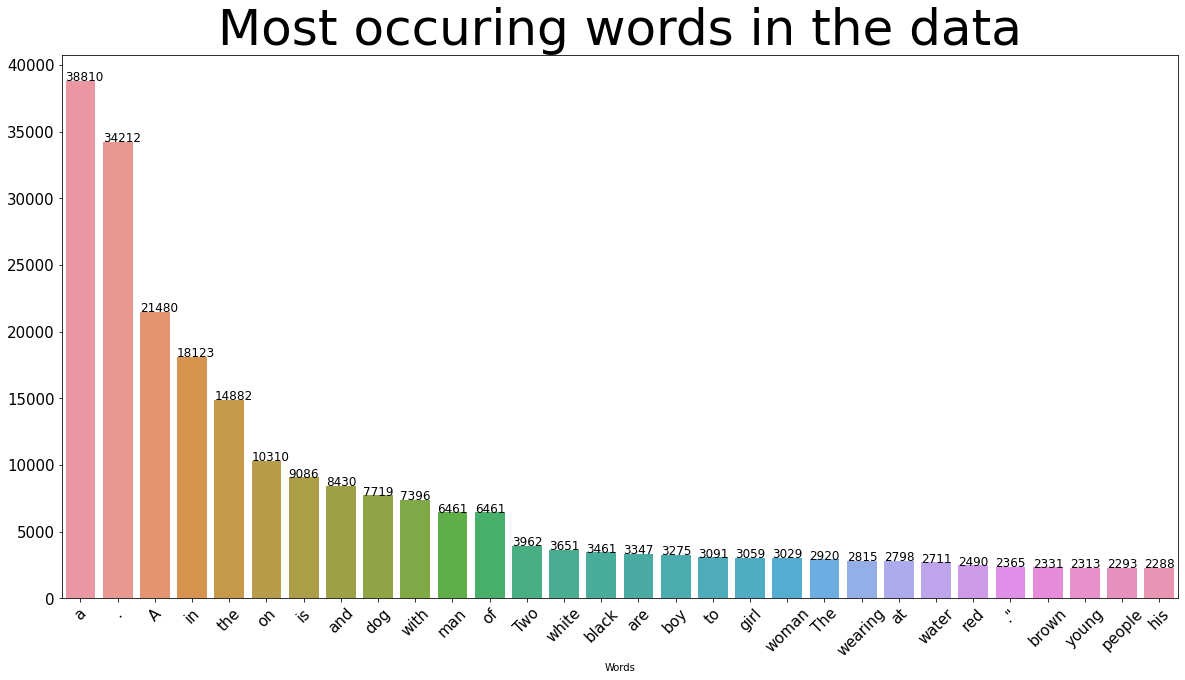

In [10]:
# Visualizing the most occuring words in the captions

plt.figure(figsize=(20,10))
ax=sns.barplot(x=counts['Words'][:30],y=counts['Count'][:30])

#Loop to show the counts over the bars of the plot
for i in ax.patches:
    ax.annotate(str(int(i.get_height())),(i.get_x()+i.get_width()-0.8,i.get_height()),fontsize=12)
plt.title('Most occuring words in the data',fontsize=50)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(None)
plt.show()

In [11]:
# Puting the <start> and <end> tags to our captions

modified_captions = df.captions_orig.apply(lambda x: '<start>'+' '+x+' '+'<end>')
print('Total Number of captions in the data -',len(modified_captions))

Total Number of captions in the data - 40455


In [12]:
# Putiing the modified_captions in the data frame

df['modified_captions'] = modified_captions
df.head()

,image_id,image_path,captions_orig,modified_captions
0,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n,<start> A child in a pink dress is climbing up a set of stairs in an entry way .\n <end>
1,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n,<start> A girl going into a wooden building .\n <end>
2,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n,<start> A little girl climbing into a wooden playhouse .\n <end>
3,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n,<start> A little girl climbing the stairs to her playhouse .\n <end>
4,1000268201_693b08cb0e.jpg,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n,<start> A little girl in a pink dress going into a wooden cabin .\n <end>


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [13]:
# create the tokenizer

word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(df.modified_captions)
train_seqs = tokenizer.texts_to_sequences(df.modified_captions)

In [14]:
a1=0

for i,j in tokenizer.word_counts.items():
    print(f'{i}   -   {j}')
    if a1==20:
        break
    a1+=1

<start>   -   40455
a   -   60351
child   -   1484
in   -   18137
pink   -   684
dress   -   327
is   -   9086
climbing   -   486
up   -   1252
set   -   98
of   -   6470
stairs   -   100
an   -   2325
entry   -   1
way   -   51

   -   36742
<end>   -   40455
girl   -   3159
going   -   146
into   -   1054
wooden   -   280


In [15]:
train_seqs[:5]

[[3, 2, 44, 6, 2, 93, 174, 9, 118, 53, 2, 415, 14, 407, 6, 30, 1, 673, 5, 4],
 [3, 2, 21, 308, 64, 2, 192, 120, 5, 4],
 [3, 2, 41, 21, 118, 64, 2, 192, 3044, 5, 4],
 [3, 2, 41, 21, 118, 7, 407, 22, 61, 3044, 5, 4],
 [3, 2, 41, 21, 6, 2, 93, 174, 308, 64, 2, 192, 3513, 5, 4]]

In [16]:
# Create word-to-index and index-to-word mappings.

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(modified_captions)

a1=0

for i,j in tokenizer.word_counts.items():
    print(f'{i}   -   {j}')
    if a1==20:
        break
    a1+=1

<start>   -   40455
a   -   60351
child   -   1484
in   -   18137
pink   -   684
dress   -   327
is   -   9086
climbing   -   486
up   -   1252
set   -   98
of   -   6470
stairs   -   100
an   -   2325
entry   -   1
way   -   51

   -   36742
<end>   -   40455
girl   -   3159
going   -   146
into   -   1054
wooden   -   280


In [17]:
# After Tagging the captions 

words=[]
counts=[]
for i,j in tokenizer.word_counts.items():
    words.append(i)
    counts.append(j)

embedded_text=pd.DataFrame()
embedded_text['Words'] = words
embedded_text['Counts'] =counts

embedded_text.sort_values('Counts',ascending=False,inplace=True)

In [18]:
embedded_text.head(30)

,Words,Counts
1,a,60351
0,<start>,40455
16,<end>,40455
15,\n,36742
3,in,18137
24,the,17806
40,on,10297
6,is,9086
30,and,8439
29,dog,7832


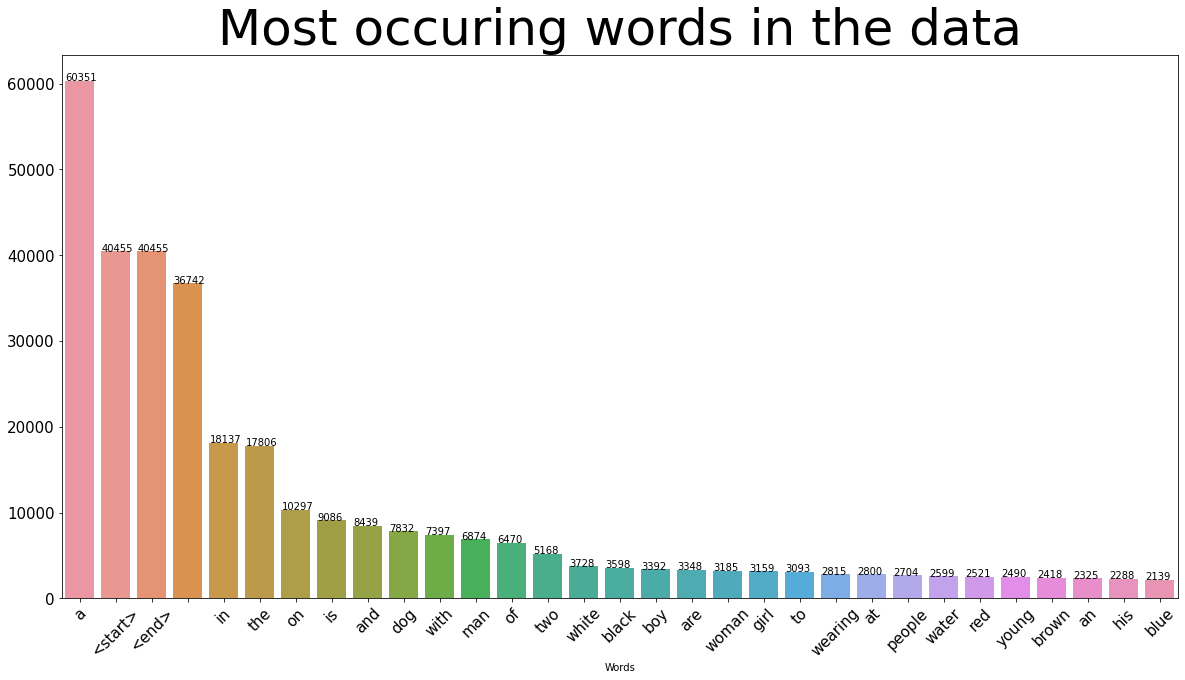

In [19]:
# VIsualizing the most occuring words in the captions

plt.figure(figsize=(20,10))
ax=sns.barplot(x=embedded_text['Words'][:31],y=embedded_text['Counts'][:31])

#Loop to show the counts over the bars of the plot
for i in ax.patches:
    ax.annotate(str(int(i.get_height())),(i.get_x()+i.get_width()-0.8,i.get_height()),fontsize=10)
plt.title('Most occuring words in the data',fontsize=50)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(None)
plt.show()

In [20]:
# taking out the length of the longest caption/sequence of words 
length = [len(i) for i in train_seqs]

# Taking the max and min lengths off from the length 
max_length,min_length = max(length),min(length)
print(max_length,min_length)

36 3


In [21]:
# Creating the caption vector 

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_length)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 36)


## Pre-processing the images

1. Resize them into the shape of (299, 299)

2. Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


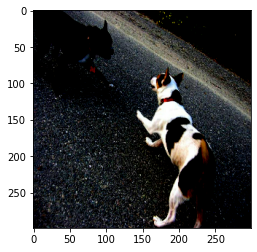

In [22]:
# Loading the images

def path_of_images(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,size=(299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img,image_path
plt.imshow(path_of_images(df['image_path'][6])[0])

In [23]:
data = df[['image_path','modified_captions']].copy()
data.head()

,image_path,modified_captions
0,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,<start> A child in a pink dress is climbing up a set of stairs in an entry way .\n <end>
1,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,<start> A girl going into a wooden building .\n <end>
2,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,<start> A little girl climbing into a wooden playhouse .\n <end>
3,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,<start> A little girl climbing the stairs to her playhouse .\n <end>
4,../input/flicker8k-data/Images/1000268201_693b08cb0e.jpg,<start> A little girl in a pink dress going into a wooden cabin .\n <end>


In [24]:
# Getting the path of the images from the data frame
path_img = sorted(set(data['image_path']))

# Creating the dataset
image_data_set = tf.data.Dataset.from_tensor_slices(path_img)

image_data_set = image_data_set.map(path_of_images, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [25]:
# Splitting the data using train_test_split into the particular train and test sets

from sklearn.model_selection import train_test_split

img_train,img_test,cap_train,cap_test = train_test_split(data['image_path'],cap_vector,test_size=0.2,random_state=42)

cap_train.shape

(32364, 36)

In [26]:
print("Training data for images: " + str(len(img_train)))
print("Testing data for images: " + str(len(img_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [27]:
# Loading the Inception V3 Model

image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input

hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input,hidden_layer)

87916544/87910968 [==============================] - 0s 0us/step


In [28]:
# Checking the summary of the model 

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [29]:
# Creating the map function for tensors
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

In [30]:
from tqdm import tqdm

# Processing the data for modelling

feature_dict = {}

for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()
batch_f.shape

100%|██████████| 253/253 [01:02<00:00,  4.06it/s]


TensorShape([64, 2048])

In [31]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

batch_size = 32
buffer_size = 1000


# Creating the function to geneerate data set
def gen_dataset(image_path,captions):
    
    dataset = tf.data.Dataset.from_tensor_slices((image_path,captions))
    dataset = dataset.shuffle(buffer_size)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [32]:
# Creating the train and test data sets for modelling

train_set = gen_dataset(img_train,cap_train)
test_set = gen_dataset(img_test,cap_test)

In [33]:
# Checking the shape of the input data

img,cap = next(iter(train_set))

print('Shape of the img data - ',img.shape)
print('Shape of the cap data - ',cap.shape)

Shape of the img data -  (32, 64, 2048)
Shape of the cap data -  (32, 36)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [34]:
# Setting the attributes for the model training

embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train) // batch_size
test_num_steps = len(img_test) // batch_size

## Encoder

In [35]:
# Defining the encoder model class

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features
    
encoder = Encoder(embedding_dim)

## Attention Model

In [36]:
# Defining the attention model class

class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

## Decoder

In [37]:
# Defining the class for decoder

class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [38]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [39]:
features=encoder(img)

hidden = decoder.init_state(batch_size=cap.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * cap.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) 
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) 
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [40]:
# Setting th optimizers
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [41]:
# Creating the function for loss functions
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [42]:
os.getcwd()

'/kaggle/working'

In [43]:
# Creating the checkpoint for the model 

checkpoint_path = '/kaggle/working'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

In [44]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [45]:
# Creating the decorator for the train_step

@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [46]:
# Creating the decorator for test_step

@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [47]:
# Function for calling the test loss

def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [48]:
import time
tf.config.run_functions_eagerly(True)

In [49]:
# Training the model 


loss_plot = []
test_loss_plot = []
EPOCHS = 25

best_test_loss = 100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_set):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_set)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  4%|▍         | 1/25 [10:51<4:20:32, 651.37s/it]

For epoch: 1, the train loss is 1.256, & test loss is 1.058
Time taken for 1 epoch 651.2419998645782 sec

Test loss has been reduced from 100.000 to 1.058


  8%|▊         | 2/25 [21:38<4:08:40, 648.73s/it]

For epoch: 2, the train loss is 0.984, & test loss is 0.939
Time taken for 1 epoch 646.7567822933197 sec

Test loss has been reduced from 1.058 to 0.939


 12%|█▏        | 3/25 [32:24<3:57:28, 647.64s/it]

For epoch: 3, the train loss is 0.896, & test loss is 0.865
Time taken for 1 epoch 646.2178101539612 sec

Test loss has been reduced from 0.939 to 0.865


 16%|█▌        | 4/25 [43:08<3:46:13, 646.35s/it]

For epoch: 4, the train loss is 0.833, & test loss is 0.808
Time taken for 1 epoch 644.229656457901 sec

Test loss has been reduced from 0.865 to 0.808


 20%|██        | 5/25 [54:26<3:39:10, 657.54s/it]

For epoch: 5, the train loss is 0.781, & test loss is 0.760
Time taken for 1 epoch 677.2694368362427 sec

Test loss has been reduced from 0.808 to 0.760


 24%|██▍       | 6/25 [1:05:46<3:30:40, 665.28s/it]

For epoch: 6, the train loss is 0.736, & test loss is 0.716
Time taken for 1 epoch 680.1795964241028 sec

Test loss has been reduced from 0.760 to 0.716


 28%|██▊       | 7/25 [1:16:56<3:20:00, 666.71s/it]

For epoch: 7, the train loss is 0.693, & test loss is 0.677
Time taken for 1 epoch 669.5123760700226 sec

Test loss has been reduced from 0.716 to 0.677


 32%|███▏      | 8/25 [1:27:51<3:07:50, 662.99s/it]

For epoch: 8, the train loss is 0.655, & test loss is 0.640
Time taken for 1 epoch 654.9013841152191 sec

Test loss has been reduced from 0.677 to 0.640


 36%|███▌      | 9/25 [1:39:11<2:58:12, 668.28s/it]

For epoch: 9, the train loss is 0.620, & test loss is 0.606
Time taken for 1 epoch 679.781133890152 sec

Test loss has been reduced from 0.640 to 0.606


 40%|████      | 10/25 [1:50:33<2:48:08, 672.57s/it]

For epoch: 10, the train loss is 0.588, & test loss is 0.575
Time taken for 1 epoch 682.0400295257568 sec

Test loss has been reduced from 0.606 to 0.575


 44%|████▍     | 11/25 [2:01:24<2:35:23, 665.99s/it]

For epoch: 11, the train loss is 0.558, & test loss is 0.546
Time taken for 1 epoch 650.9178640842438 sec

Test loss has been reduced from 0.575 to 0.546


 48%|████▊     | 12/25 [2:12:10<2:22:59, 659.95s/it]

For epoch: 12, the train loss is 0.531, & test loss is 0.521
Time taken for 1 epoch 646.003301858902 sec

Test loss has been reduced from 0.546 to 0.521


 52%|█████▏    | 13/25 [2:22:54<2:11:01, 655.11s/it]

For epoch: 13, the train loss is 0.507, & test loss is 0.497
Time taken for 1 epoch 643.8474545478821 sec

Test loss has been reduced from 0.521 to 0.497


 56%|█████▌    | 14/25 [2:33:38<1:59:28, 651.68s/it]

For epoch: 14, the train loss is 0.484, & test loss is 0.479
Time taken for 1 epoch 643.6279788017273 sec

Test loss has been reduced from 0.497 to 0.479


 60%|██████    | 15/25 [2:44:23<1:48:18, 649.80s/it]

For epoch: 15, the train loss is 0.464, & test loss is 0.459
Time taken for 1 epoch 645.3201446533203 sec

Test loss has been reduced from 0.479 to 0.459


 64%|██████▍   | 16/25 [2:55:10<1:37:19, 648.80s/it]

For epoch: 16, the train loss is 0.445, & test loss is 0.440
Time taken for 1 epoch 646.3170158863068 sec

Test loss has been reduced from 0.459 to 0.440


 68%|██████▊   | 17/25 [3:05:56<1:26:24, 648.03s/it]

For epoch: 17, the train loss is 0.428, & test loss is 0.421
Time taken for 1 epoch 646.0848126411438 sec

Test loss has been reduced from 0.440 to 0.421


 72%|███████▏  | 18/25 [3:16:39<1:15:26, 646.66s/it]

For epoch: 18, the train loss is 0.414, & test loss is 0.409
Time taken for 1 epoch 643.3644149303436 sec

Test loss has been reduced from 0.421 to 0.409


 76%|███████▌  | 19/25 [3:27:26<1:04:39, 646.54s/it]

For epoch: 19, the train loss is 0.398, & test loss is 0.397
Time taken for 1 epoch 646.0696089267731 sec

Test loss has been reduced from 0.409 to 0.397


 80%|████████  | 20/25 [3:38:12<53:52, 646.51s/it]  

For epoch: 20, the train loss is 0.387, & test loss is 0.384
Time taken for 1 epoch 646.3199532032013 sec

Test loss has been reduced from 0.397 to 0.384


 84%|████████▍ | 21/25 [3:48:58<43:05, 646.30s/it]

For epoch: 21, the train loss is 0.375, & test loss is 0.370
Time taken for 1 epoch 645.6642727851868 sec

Test loss has been reduced from 0.384 to 0.370


 88%|████████▊ | 22/25 [3:59:43<32:17, 645.95s/it]

For epoch: 22, the train loss is 0.365, & test loss is 0.363
Time taken for 1 epoch 645.027679681778 sec

Test loss has been reduced from 0.370 to 0.363


 92%|█████████▏| 23/25 [4:10:27<21:30, 645.38s/it]

For epoch: 23, the train loss is 0.355, & test loss is 0.352
Time taken for 1 epoch 643.9173307418823 sec

Test loss has been reduced from 0.363 to 0.352


 96%|█████████▌| 24/25 [4:21:19<10:47, 647.34s/it]

For epoch: 24, the train loss is 0.346, & test loss is 0.344
Time taken for 1 epoch 651.7798526287079 sec

Test loss has been reduced from 0.352 to 0.344


100%|██████████| 25/25 [4:32:10<00:00, 653.23s/it]

For epoch: 25, the train loss is 0.336, & test loss is 0.334
Time taken for 1 epoch 651.0776219367981 sec

Test loss has been reduced from 0.344 to 0.334


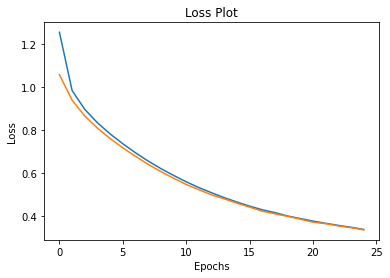

In [50]:
# Plotting the loss curves
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [51]:
def evaluate(image,max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(path_of_images(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)  # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions


        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [52]:
def beam_evaluate(image, max_length,beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(path_of_images(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [53]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [54]:
from nltk.translate.bleu_score import sentence_bleu

In [55]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [56]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

# Testing the model

2446
BELU score: 56.23413251903491
Real Caption: walking across a street
Prediction Caption: a group of people stand in front of a building 



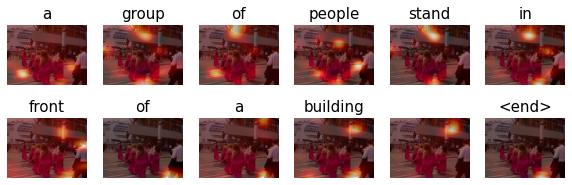

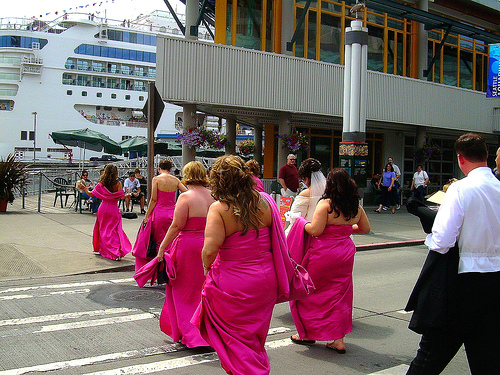

In [57]:
# Testing the model
rid = np.random.randint(0, len(img_test))
print(rid)
test_image = img_test.iloc[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image,max_length)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)) # Setting the weights
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [58]:
# Predictions
captions=beam_evaluate(test_image,max_length)
print(pred_caption)

a group of people stand in front of a building 



# Converting text to audio

In [59]:
!pip install gtts

In [60]:
# Libraary to convert the predicted caption into audio file
from gtts import gTTS

from IPython import display

In [61]:
# Creating the object for audio_file
audio_file = gTTS(text = pred_caption,lang='en',slow=False)

# Saving the audio file
audio_file.save('Predicted_caption_from_image.mp3')

In [62]:
# Displaying the result 
display.display(display.Audio('Predicted_caption_from_image.mp3',rate=2))